from google.colab import drive
drive.mount('/content/drive')



import os

# Permanent project directory (Google Drive)
PROJECT_DIR = "/content/drive/MyDrive/ANN_Project"

folders = ["data", "models", "results", "plots"]

os.makedirs(PROJECT_DIR, exist_ok=True)

for folder in folders:
    os.makedirs(os.path.join(PROJECT_DIR, folder), exist_ok=True)

print("✅ Project folders created permanently in Google Drive")


from google.colab import files

uploaded = files.upload()

import shutil

source_path = "/content/Modified_HR_Employee_Attrition.csv"
destination_path = f"{PROJECT_DIR}/data/Modified_HR_Employee_Attrition.csv"

shutil.move(source_path, destination_path)

print("✅ Dataset moved to Google Drive safely!")




In [368]:
# =========================================
# 1. IMPORT LIBRARIES
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import zscore


In [369]:
# =========================================
# 2. LOAD DATASET (FROM GOOGLE DRIVE)
# =========================================
DATA_PATH = "/content/drive/MyDrive/ANN_Project/data/Modified_HR_Employee_Attrition.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,Yes,Travel_Rarely,NaN,Sales,1,2,Life Sciences,1,1,...,1,80,0,8.0,0,1,6,4,0,5
1,49.0,No,Travel_Frequently,279.0,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10.0,3,3,10,7,1,7
2,37.0,Yes,Travel_Rarely,1373.0,Research & Development,2,2,Other,1,4,...,2,80,0,7.0,3,3,0,0,0,0
3,33.0,No,Travel_Frequently,1392.0,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8.0,3,3,8,7,3,0
4,NaN,No,Travel_Rarely,591.0,Research & Development,2,1,Medical,1,7,...,4,80,1,6.0,3,3,2,2,2,2


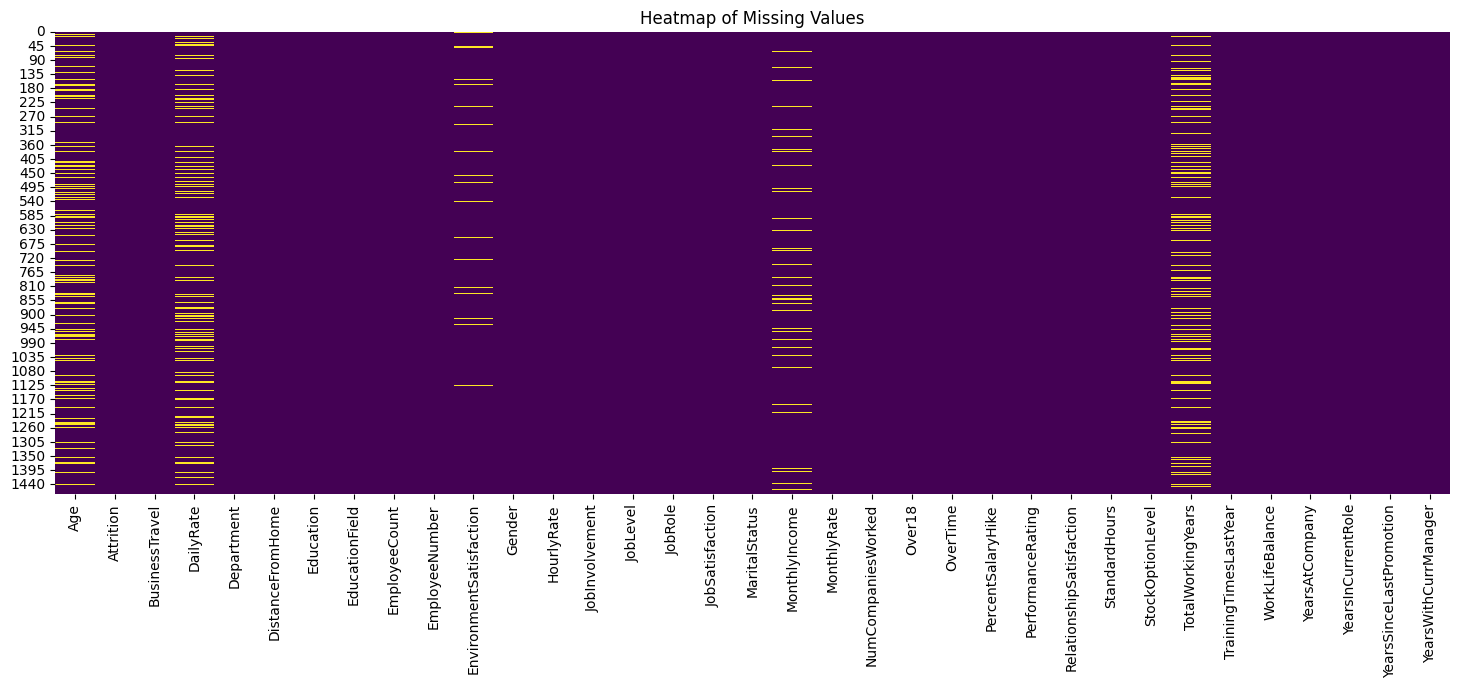

In [370]:
# =========================================
# 3. MISSING VALUES HEATMAP
# =========================================
plt.figure(figsize=(18, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.show()


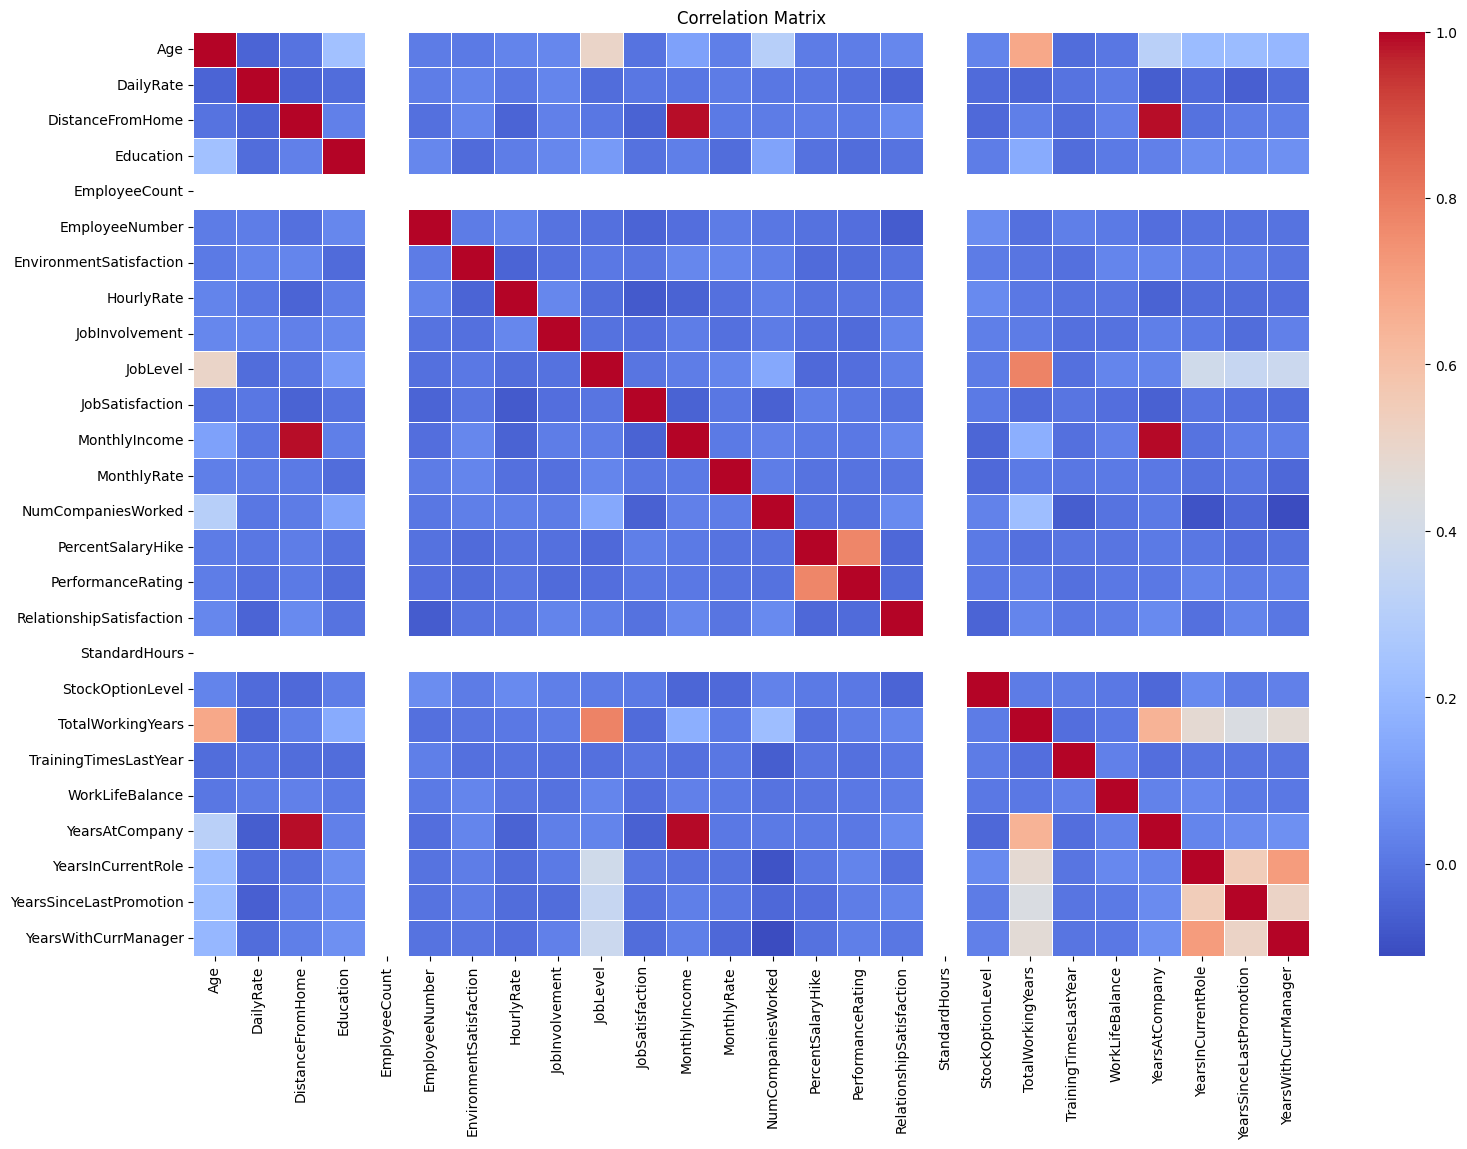

In [371]:
# =========================================
# 4. CORRELATION MATRIX (NUMERICAL)
# =========================================
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(18, 12))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


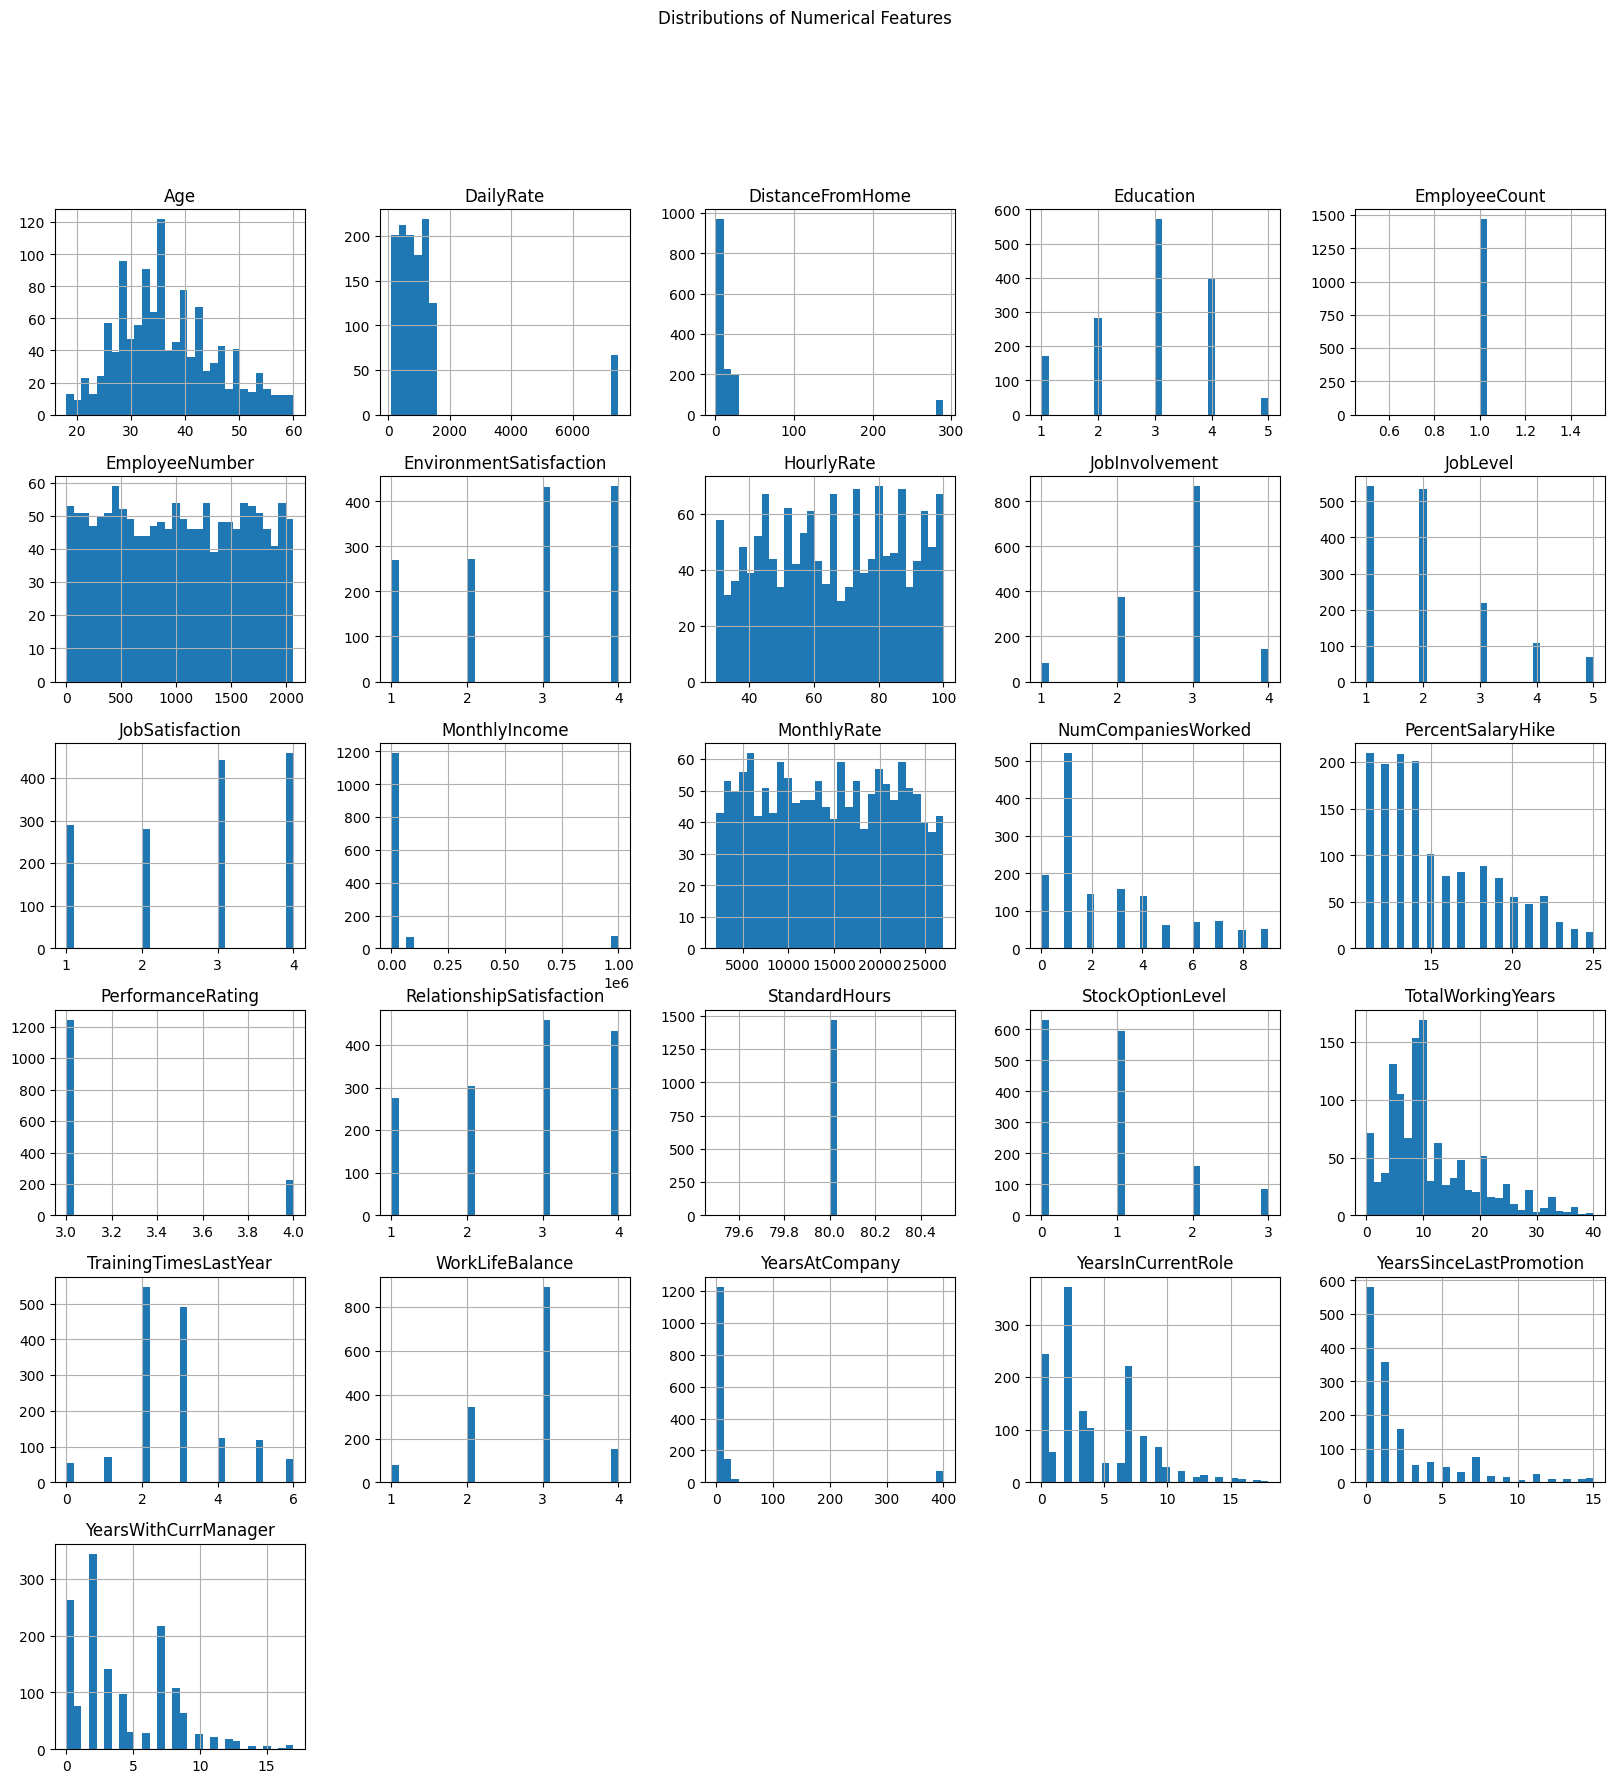

In [372]:
# =========================================
# 5. HISTOGRAMS FOR NUMERICAL COLUMNS
# =========================================
numeric_df.hist(bins=30, figsize=(20, 20))
plt.suptitle("Distributions of Numerical Features")
plt.show()


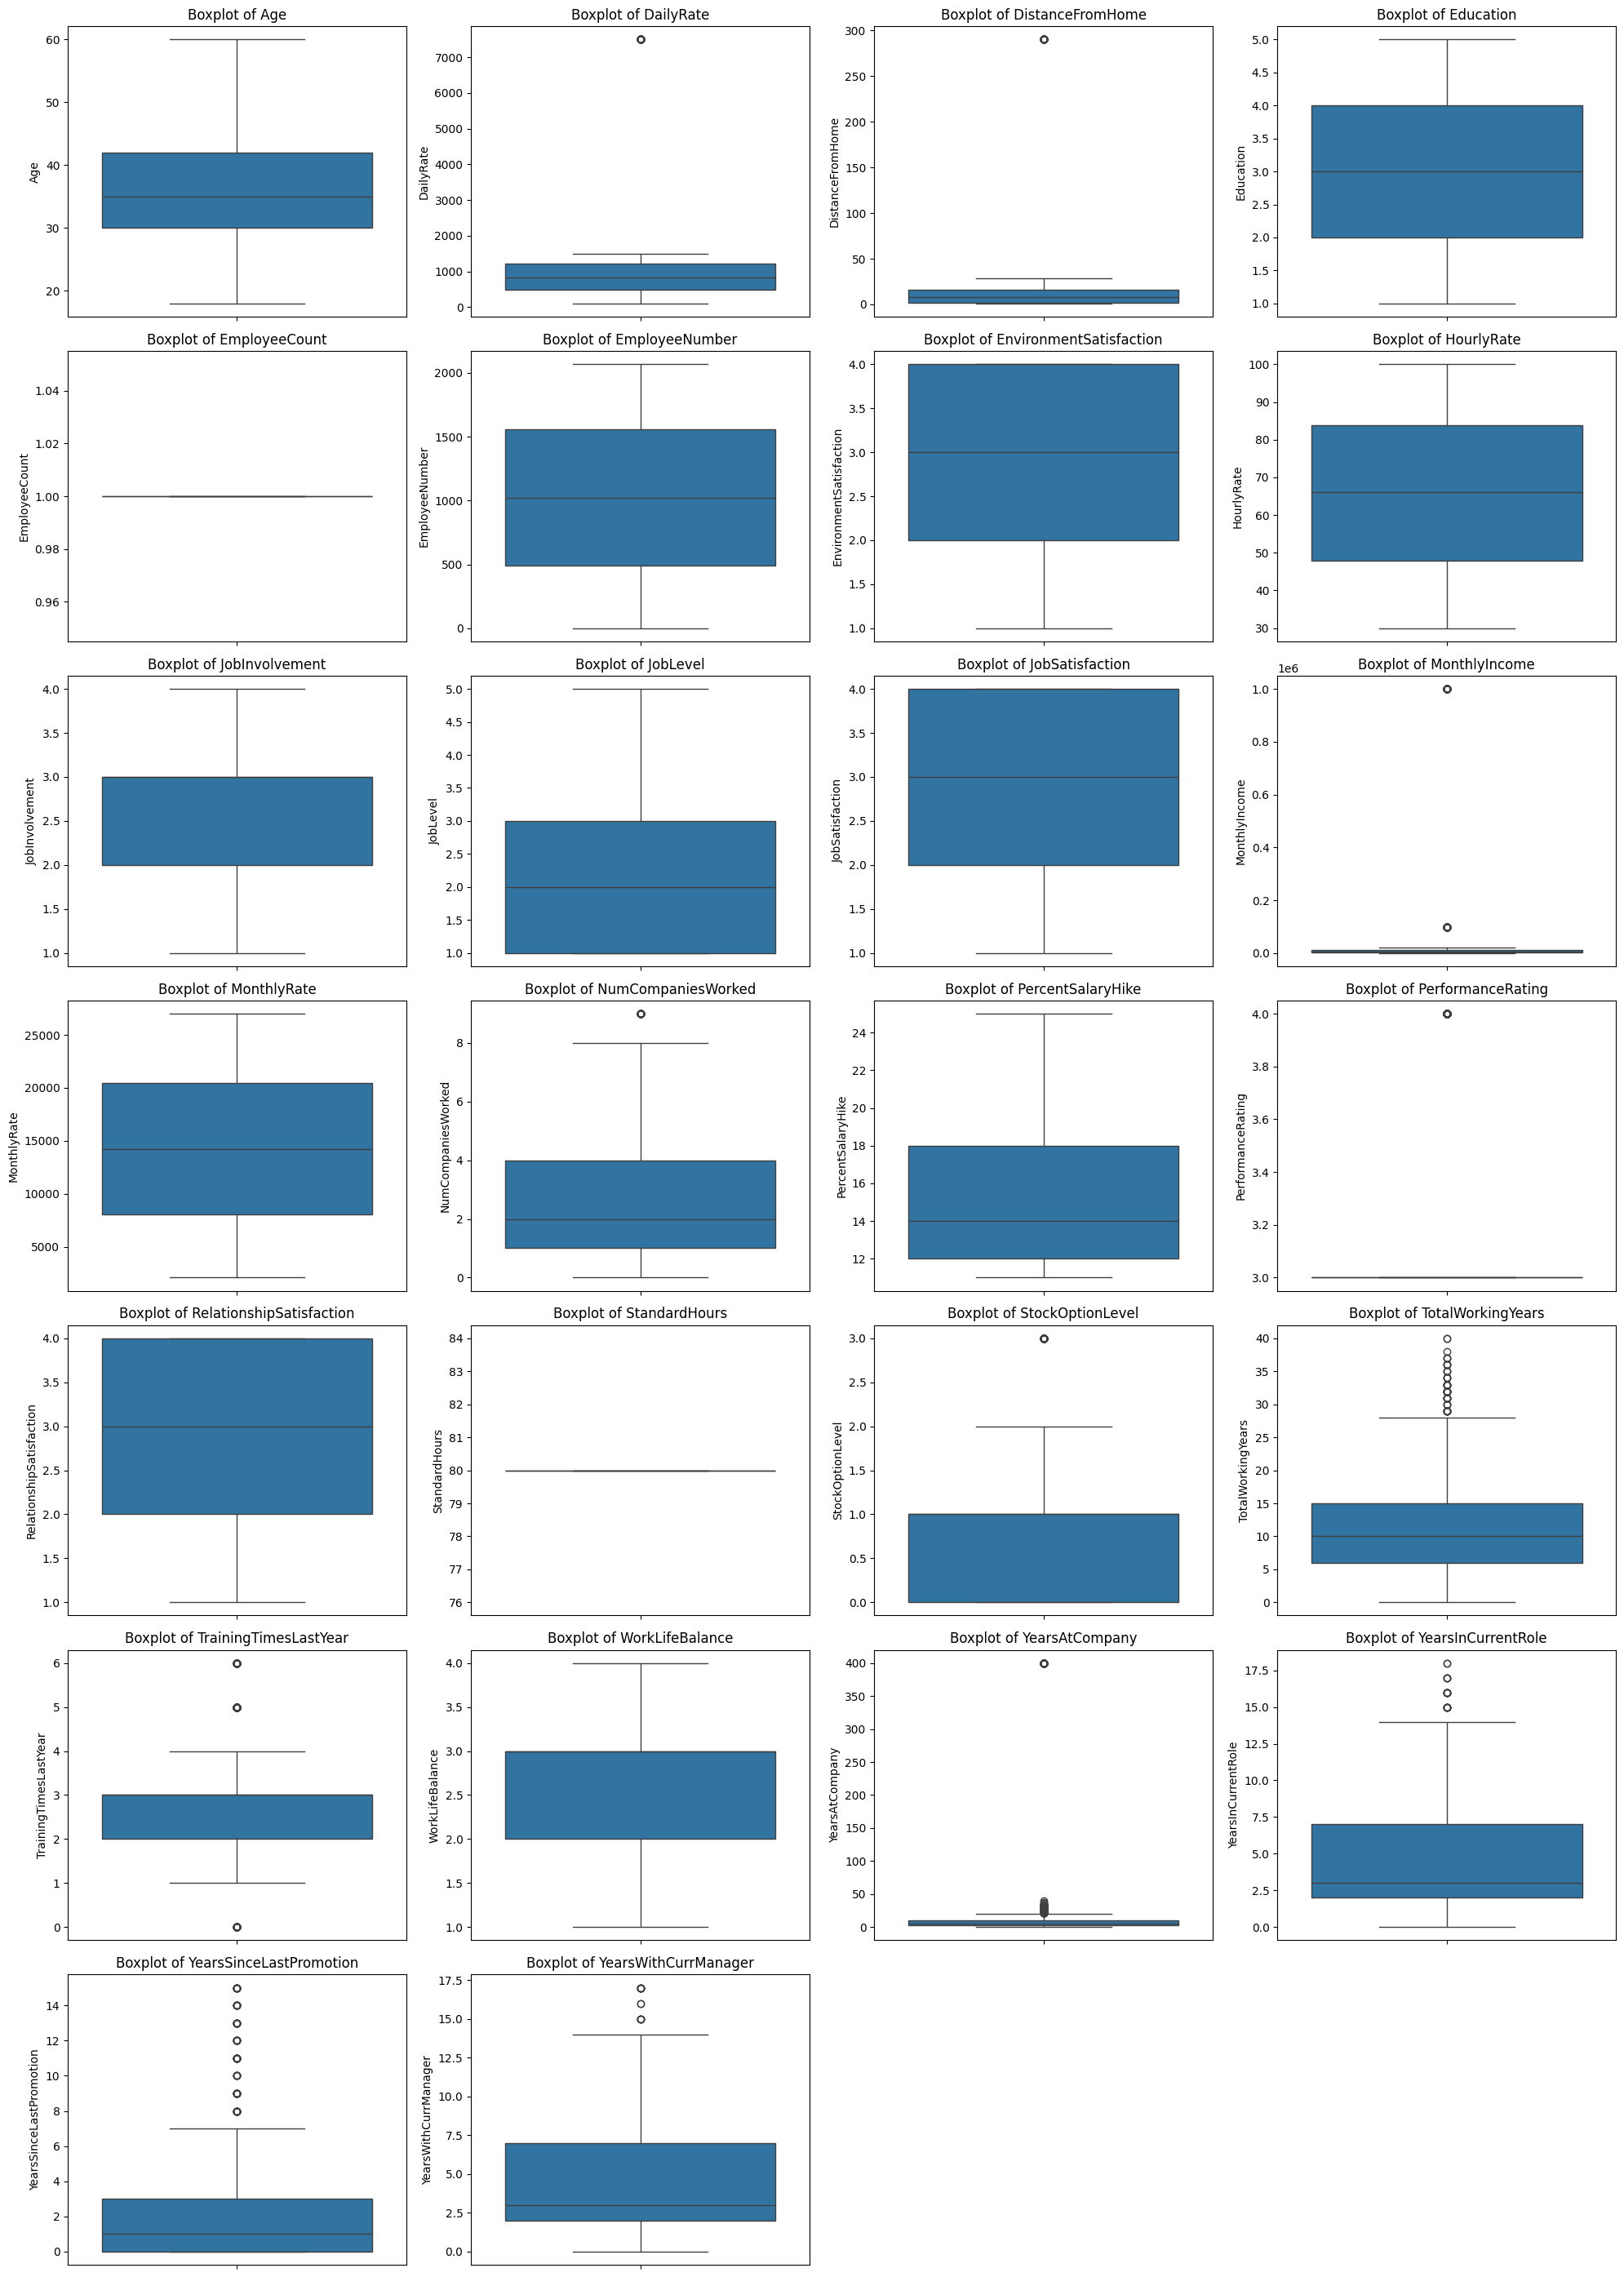

In [373]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = len(numeric_df.columns)
cols_per_row = 4
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(20, rows * 4))

for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


In [374]:
# =========================================
# 7. DEFINE COLUMN GROUPS
# =========================================
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender',
                    'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

ordinal_cols = ['Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement',
                'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating',
                'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
                'TrainingTimesLastYear', 'WorkLifeBalance']

numerical_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'EmployeeNumber',
                  'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike',
                  'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
                  'YearsSinceLastPromotion', 'YearsWithCurrManager']

normal_numerical = ['Age', 'HourlyRate', 'MonthlyRate']
skewed_numerical = [col for col in numerical_cols if col not in normal_numerical]


In [375]:
# =========================================
# 8. CUSTOM TRANSFORMERS
# =========================================
class MeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        self.means = X[self.columns].mean()
        return self
    def transform(self, X):
        X = X.copy()
        X[self.columns] = X[self.columns].fillna(self.means)
        return X


class MedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        self.medians = X[self.columns].median()
        return self
    def transform(self, X):
        X = X.copy()
        X[self.columns] = X[self.columns].fillna(self.medians)
        return X


class ModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        self.modes = X[self.columns].mode().iloc[0]
        return self
    def transform(self, X):
        X = X.copy()
        X[self.columns] = X[self.columns].fillna(self.modes)
        return X


class ZScoreOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns, threshold=3):
        self.columns = columns
        self.threshold = threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            z = (X[col] - X[col].mean()) / X[col].std()
            X.loc[np.abs(z) > self.threshold, col] = X[col].median()
        return X


class IQROutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            X[col] = np.where((X[col] < lower) | (X[col] > upper),
                              X[col].median(), X[col])
        return X


In [376]:
# =========================================
# 9. PIPELINES
# =========================================
categorical_pipeline = Pipeline(steps=[
    ('mode_imputer', ModeImputer(categorical_cols)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[
    ('mode_imputer', ModeImputer(ordinal_cols)),
    ('ordinal', OrdinalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('mean_imputer', MeanImputer(normal_numerical)),
    ('median_imputer', MedianImputer(skewed_numerical)),
    ('zscore_outlier', ZScoreOutlierHandler(normal_numerical)),
    ('iqr_outlier', IQROutlierHandler(skewed_numerical)),
    ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_cols),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('num', numerical_pipeline, numerical_cols)
])


In [377]:
# =========================================
# 10. SPLIT DATA (70 / 20 / 10)
# =========================================
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (1029, 34)
Validation: (294, 34)
Test: (147, 34)


In [378]:
# =========================================================
# FIX: Convert target labels from Yes/No to 1/0
# =========================================================

y_train = y_train.map({'Yes': 1, 'No': 0})
y_val   = y_val.map({'Yes': 1, 'No': 0})
y_test  = y_test.map({'Yes': 1, 'No': 0})


In [379]:
# =========================================
# 11. APPLY PREPROCESSING
# =========================================
X_train_processed = full_pipeline.fit_transform(X_train)
X_val_processed = full_pipeline.transform(X_val)
X_test_processed = full_pipeline.transform(X_test)


/tmp/ipython-input-2478098603.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14434.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[np.abs(z) > self.threshold, col] = X[col].median()


In [380]:
# =========================================================
# FIX: Convert processed features to float32
# =========================================================

X_train_processed = X_train_processed.astype('float32')
X_val_processed   = X_val_processed.astype('float32')
X_test_processed  = X_test_processed.astype('float32')


In [381]:
y_train = y_train.astype('int')
y_val   = y_val.astype('int')
y_test  = y_test.astype('int')


In [382]:
# =========================================
# 12. FINAL SHAPES CHECK
# =========================================
print("Processed Train Shape:", X_train_processed.shape)
print("Processed Validation Shape:", X_val_processed.shape)
print("Processed Test Shape:", X_test_processed.shape)


Processed Train Shape: (1029, 55)
Processed Validation Shape: (294, 55)
Processed Test Shape: (147, 55)


**Simple model only activation function and hidden layers:**

In [383]:
# ============================================================
# PHASE 2: NEURAL NETWORK DESIGN (BASELINE ARCHITECTURE)
# ============================================================
# This phase focuses ONLY on architecture design.
# No batch normalization, no dropout, no regularization.
# The goal is to design a simple ANN based on dataset nature.
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

def build_phase2_baseline_model(input_dim):
    """
   E
    Baseline ANN Model for Phase 2 (Design Phase)

    Parameters:
    -----------
    input_dim : int
        Number of input features after preprocessing.

    Returns:
    --------
    model : keras Sequential model
        Compiled baseline ANN model.
    """

    # Initialize Sequential model
    model = Sequential()

    # -------------------------------
    # Input Layer
    # -------------------------------
    # Defines input shape based on number of features
    model.add(Input(shape=(input_dim,)))

    # -------------------------------
    # Hidden Layer 1
    # -------------------------------
    # 128 neurons chosen to capture complex feature interactions
    # ReLU activation used to avoid vanishing gradients
    model.add(Dense(128, activation='relu'))

    # -------------------------------
    # Hidden Layer 2
    # -------------------------------
    # Reduced neurons for hierarchical feature abstraction
    model.add(Dense(64, activation='relu'))

    # -------------------------------
    # Hidden Layer 3
    # -------------------------------
    # Further reduction to prevent unnecessary complexity
    model.add(Dense(32, activation='relu'))

    # -------------------------------
    # Output Layer
    # -------------------------------
    # Sigmoid activation used for binary classification
    # Outputs probability between 0 and 1
    model.add(Dense(1, activation='sigmoid'))

    # -------------------------------
    # Model Compilation
    # -------------------------------
    # Adam optimizer chosen as a standard baseline
    # Binary cross-entropy used for binary classification
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [384]:
# ============================================================
# VIEW MODEL ARCHITECTURE SUMMARY
# ============================================================

# Build baseline model
baseline_model = build_phase2_baseline_model(
    X_train_processed.shape[1]
)

# Print model summary
baseline_model.summary()


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_528 (Dense)               │ (None, 128)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

Training of model

In [385]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [386]:
# ============================================================
# PHASE 3: OPTIMIZER EXPERIMENTS
# ============================================================

experiments = [
    {
        "name": "Adam",
        "optimizer": Adam(learning_rate=0.001)
    },
    {
        "name": "SGD_with_Momentum",
        "optimizer": SGD(learning_rate=0.01, momentum=0.9)
    },
    {
        "name": "RMSprop",
        "optimizer": RMSprop(learning_rate=0.001)
    },
    {
        "name": "Adagrad",
        "optimizer": Adagrad(learning_rate=0.01)
    }
]

EPOCHS = 50
BATCH_SIZE = 32

results = {}


In [387]:
for exp in experiments:
    print(f"\n========== Training {exp['name']} ==========")

    # Build baseline model (Phase 2 architecture)
    model = build_phase2_baseline_model(X_train_processed.shape[1])

    # Recompile with selected optimizer
    model.compile(
        optimizer=exp["optimizer"],
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_val_processed, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Predict on test set
    y_pred = (model.predict(X_test_processed) > 0.5).astype(int)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[exp["name"]] = {
        "history": history,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")



========== Training Adam ==========
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6968 - loss: 0.5550 - val_accuracy: 0.8401 - val_loss: 0.4149
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3791 - val_accuracy: 0.8435 - val_loss: 0.4046
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8839 - loss: 0.3213 - val_accuracy: 0.8469 - val_loss: 0.3921
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8748 - loss: 0.3147 - val_accuracy: 0.8469 - val_loss: 0.3787
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8930 - loss: 0.2724 - val_accuracy: 0.8571 - val_loss: 0.3768
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8948 - loss: 0.2662 - val_accuracy: 0.8639 - val_loss: 0.3651
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9123 - loss: 0.2622 - val_accuracy: 0.8503 - val_loss: 0.3767
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9192 - loss: 0.2

In [388]:
 results_simple = results.copy()

In [389]:
def plot_training_curves(history, title):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [390]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }


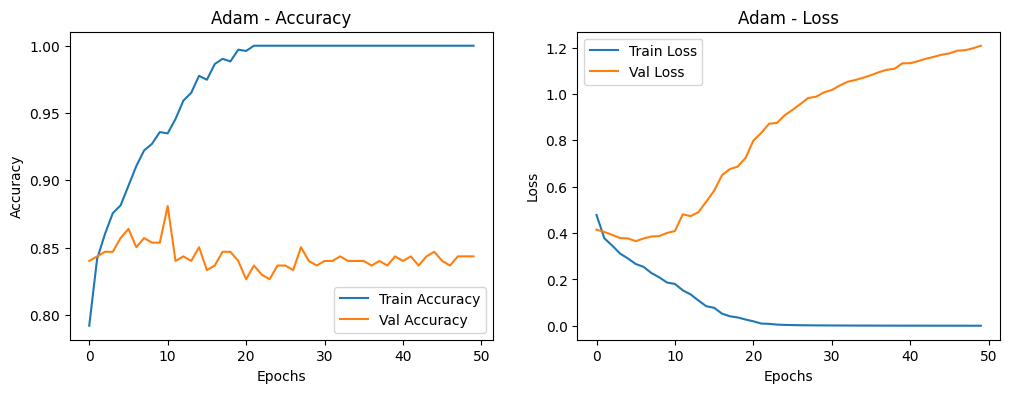

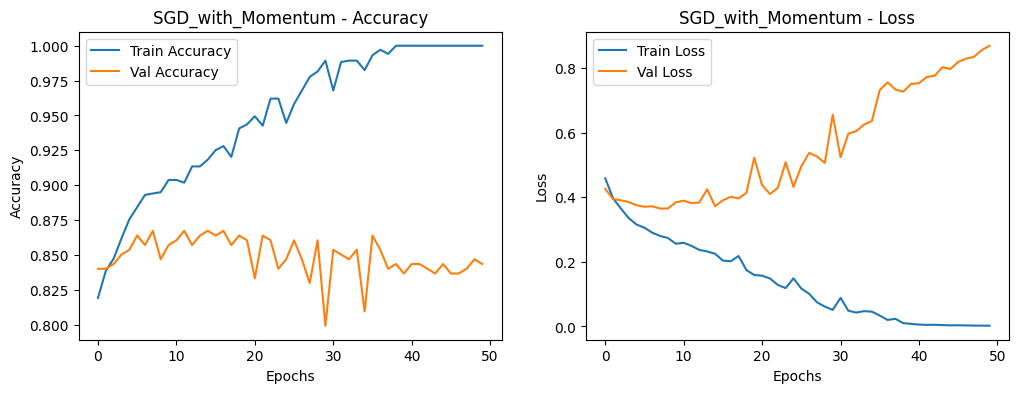

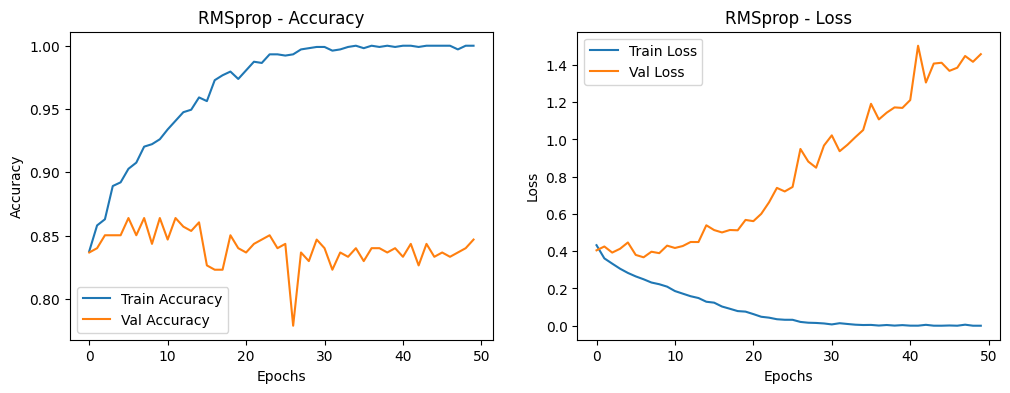

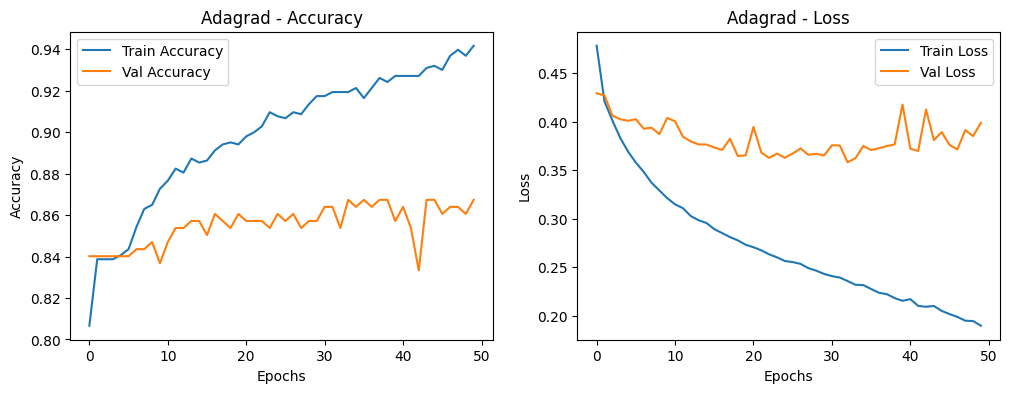

In [391]:
# ============================================================
# TRAINING CURVES (LOSS & ACCURACY)
# ============================================================

for name, res in results.items():
    history = res["history"]

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [392]:
print("\n========== OPTIMIZER COMPARISON SUMMARY ==========\n")

for name, res in results.items():
    print(f"{name}")
    print(f"Accuracy : {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall   : {res['recall']:.4f}")
    print(f"F1-score : {res['f1']:.4f}")
    print("-" * 40)



========== OPTIMIZER COMPARISON SUMMARY ==========

Adam
Accuracy : 0.8776
Precision: 0.6250
Recall   : 0.6250
F1-score : 0.6250
----------------------------------------
SGD_with_Momentum
Accuracy : 0.8912
Precision: 0.6538
Recall   : 0.7083
F1-score : 0.6800
----------------------------------------
RMSprop
Accuracy : 0.8844
Precision: 0.6522
Recall   : 0.6250
F1-score : 0.6383
----------------------------------------
Adagrad
Accuracy : 0.9116
Precision: 0.8667
Recall   : 0.5417
F1-score : 0.6667
----------------------------------------


In [393]:
best_simple = max(results_simple, key=lambda k: results_simple[k]["f1"])


simple_history = results_simple[best_simple]["history"]



In [394]:
best_simple_name = max(
    results_simple,
    key=lambda k: results_simple[k]["f1"]
)

best_simple = results_simple[best_simple_name]

print("\n" + "="*60)
print(" BEST SIMPLE MODEL (Phase 3 – No Regularization)")
print("="*60)
print(f"Optimizer : {best_simple_name}")
print(f"Accuracy  : {best_simple['accuracy']:.4f}")
print(f"Precision : {best_simple['precision']:.4f}")
print(f"Recall    : {best_simple['recall']:.4f}")
print(f"F1-score  : {best_simple['f1']:.4f}")
print("="*60)



 BEST SIMPLE MODEL (Phase 3 – No Regularization)
Optimizer : SGD_with_Momentum
Accuracy  : 0.8912
Precision : 0.6538
Recall    : 0.7083
F1-score  : 0.6800


In [395]:
best_simple_name


'SGD_with_Momentum'

Testing simple model

In [396]:

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

optimizer_map = {
    "Adam": Adam(learning_rate=0.001),
    "SGD_with_Momentum": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Adagrad": Adagrad(learning_rate=0.01)
}

best_simple_optimizer = optimizer_map[best_simple_name]


In [397]:
# =========================================
# FINAL SIMPLE MODEL TRAINING
# =========================================

final_simple_model = build_phase2_baseline_model(
    X_train_processed.shape[1]
)

# Recompile with BEST optimizer
final_simple_model.compile(
    optimizer=best_simple_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_simple_final = final_simple_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6840 - loss: 0.5661 - val_accuracy: 0.8401 - val_loss: 0.4132
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8335 - loss: 0.4066 - val_accuracy: 0.8401 - val_loss: 0.3994
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8552 - loss: 0.3523 - val_accuracy: 0.8401 - val_loss: 0.3957
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8364 - loss: 0.3634 - val_accuracy: 0.8469 - val_loss: 0.3991
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8736 - loss: 0.3231 - val_accuracy: 0.8537 - val_loss: 0.3924
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8581 - loss: 0.3273 - val_accuracy: 0.8537 - val_loss: 0.3714
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8821 - loss: 0.2866 - val_accuracy: 0.8673 - val_loss: 0.3749
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8746 - loss: 0.3252 - val_accuracy: 0.8571 - val_loss

In [398]:
# =========================================
# TESTING & PREDICTION
# =========================================

y_test_pred_prob = final_simple_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [399]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("\n" + "="*60)
print(" FINAL SIMPLE MODEL – TEST SET RESULTS")
print("="*60)
print(f"Optimizer : {best_simple_name}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print("="*60)



 FINAL SIMPLE MODEL – TEST SET RESULTS
Optimizer : SGD_with_Momentum
Accuracy  : 0.9048
Precision : 0.7273
Recall    : 0.6667
F1-score  : 0.6957


In [400]:
print("\n========== CLASSIFICATION REPORT ==========")
print(classification_report(y_test, y_test_pred))



========== CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       123
           1       0.73      0.67      0.70        24

    accuracy                           0.90       147
   macro avg       0.83      0.81      0.82       147
weighted avg       0.90      0.90      0.90       147



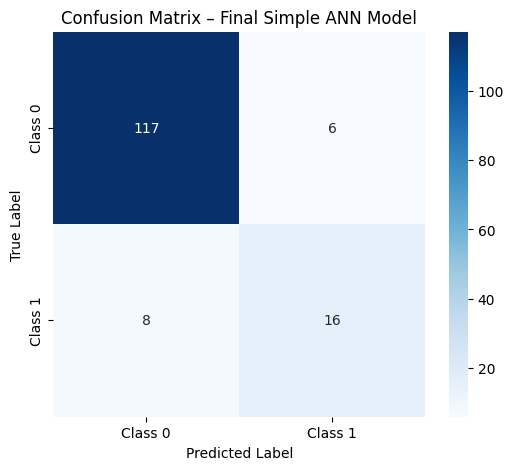

In [401]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Final Simple ANN Model")
plt.show()


now optimization model

In [402]:
# =========================================================
# PHASE 2: NEURAL NETWORK DESIGN (ANN ARCHITECTURE)
# =========================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# =========================================================
# 13. DEFINE INPUT DIMENSION
# =========================================================
input_dim = X_train_processed.shape[1]
print("Input Features:", input_dim)

# =========================================================
# 14. BUILD ANN MODEL
# =========================================================
model = Sequential(name="HR_Attrition_ANN")

# Input Layer
model.add(Input(shape=(input_dim,)))

# Hidden Layer 1
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 2
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 3
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer (Binary Classification)
model.add(Dense(1, activation='sigmoid'))

# =========================================================
# 15. COMPILE MODEL
# =========================================================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# =========================================================
# 16. MODEL SUMMARY
# =========================================================
model.summary()


Input Features: 55


Model: "HR_Attrition_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_552 (Dense)               │ (None, 128)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_279         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_553 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_280         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_281         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 448 (1.75 KB)

training model with different optimizers

In [403]:
# =========================================================
# MODEL TRAINING & EVALUATION
# =========================================================

from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [404]:
#Reusable Model Builder (Same Architecture)
from tensorflow.keras.initializers import HeNormal

def build_model(input_dim, optimizer):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    model.add(Dense(
        128,
        activation='relu',
        kernel_initializer=HeNormal()
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(
        64,
        activation='relu',
        kernel_initializer=HeNormal()
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(
        32,
        activation='relu',
        kernel_initializer=HeNormal()
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(
        1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform'
    ))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



In [405]:
#Define Optimizer Experiments
experiments = [
    {
        "name": "SGD_with_Momentum",
        "optimizer": SGD(learning_rate=0.01, momentum=0.9),
        "batch_size": 32,
        "epochs": 50
    },
    {
        "name": "Adam",
        "optimizer": Adam(learning_rate=0.001),
        "batch_size": 32,
        "epochs": 50
    },
    {
        "name": "Adagrad",
        "optimizer": Adagrad(learning_rate=0.01),
        "batch_size": 32,
        "epochs": 50
    },
    {
        "name": "RMSprop",
        "optimizer": RMSprop(learning_rate=0.001),
        "batch_size": 32,
        "epochs": 50
    }
]


In [406]:
#Training + Validation Monitoring
results = {}

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

for exp in experiments:
    print(f"\n========== Training {exp['name']} ==========")

    model = build_model(X_train_processed.shape[1], exp["optimizer"])

    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_val_processed, y_val),
        epochs=exp["epochs"],
        batch_size=exp["batch_size"],
        callbacks=[early_stop],
        verbose=1
    )

    # Test predictions
    y_pred = (model.predict(X_test_processed) > 0.5).astype(int)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[exp["name"]] = {
        "history": history,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")





========== Training SGD_with_Momentum ==========
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5715 - loss: 0.8375 - val_accuracy: 0.8401 - val_loss: 0.4087
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8106 - loss: 0.4474 - val_accuracy: 0.8401 - val_loss: 0.4141
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8401 - loss: 0.4187 - val_accuracy: 0.8401 - val_loss: 0.4143
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8437 - loss: 0.3750 - val_accuracy: 0.8435 - val_loss: 0.4136
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8485 - loss: 0.3836 - val_accuracy: 0.8469 - val_loss: 0.4043
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8412 - loss: 0.3612 - val_accuracy: 0.8469 - val_loss: 0.3991
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.3685 - val_accuracy: 0.8469 - val_loss: 0.3978
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.859

In [407]:
results_optimized = results.copy()

In [408]:
#Plot Training vs Validation Curves

def plot_history(history, title):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



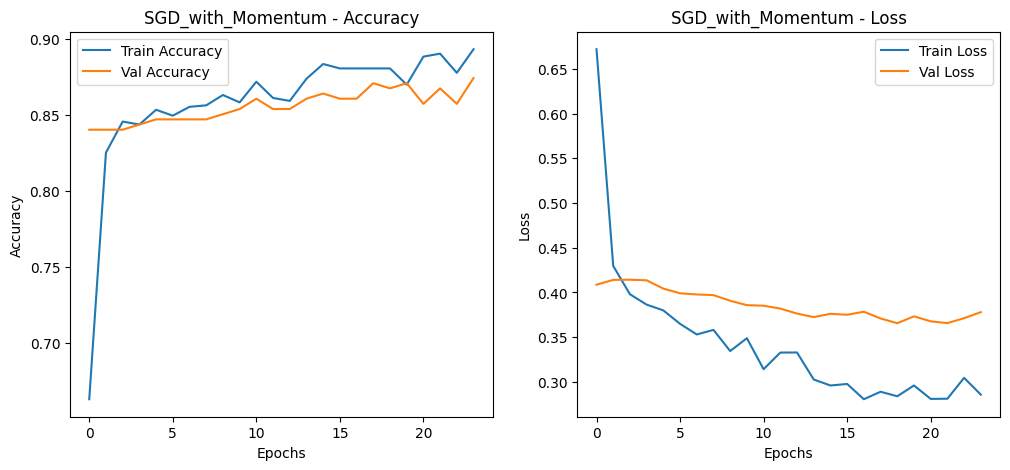

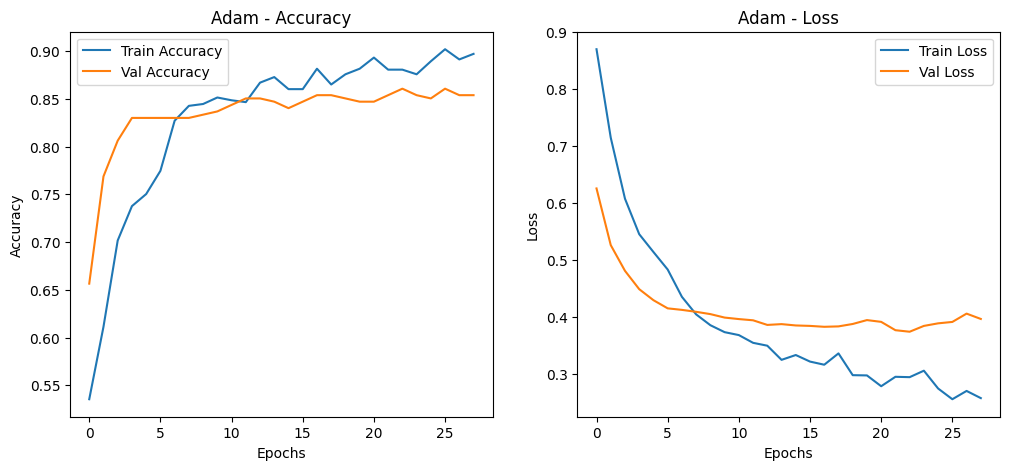

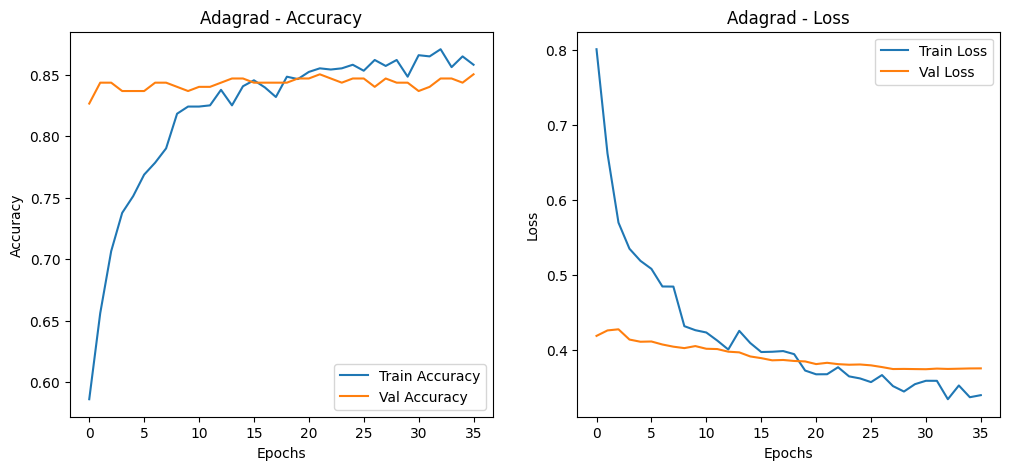

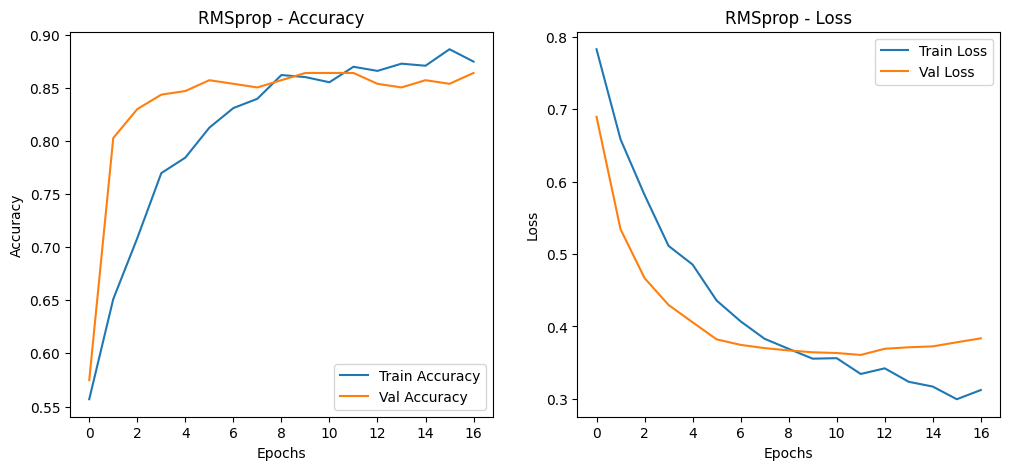

In [409]:
  #Draw Curves for Each Optimizer
for name, res in results.items():
    plot_history(res["history"], name)


In [410]:
#Final Comparison Summar
print("\n========== OPTIMIZER COMPARISON SUMMARY ==========")

for name, res in results.items():
    print(f"\n{name}")
    print(f"Accuracy : {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall   : {res['recall']:.4f}")
    print(f"F1-score : {res['f1']:.4f}")



========== OPTIMIZER COMPARISON SUMMARY ==========

SGD_with_Momentum
Accuracy : 0.8844
Precision: 0.7692
Recall   : 0.4167
F1-score : 0.5405

Adam
Accuracy : 0.8912
Precision: 0.7500
Recall   : 0.5000
F1-score : 0.6000

Adagrad
Accuracy : 0.8571
Precision: 0.6154
Recall   : 0.3333
F1-score : 0.4324

RMSprop
Accuracy : 0.8639
Precision: 0.6667
Recall   : 0.3333
F1-score : 0.4444


In [411]:
# =========================================
# SELECT BEST MODEL BASED ON F1-SCORE
# =========================================

best_optimizer = max(results, key=lambda k: results[k]["f1"])
best_result = results[best_optimizer]

print("\n" + "="*50)
print(" BEST MODEL SELECTION (Based on F1-score)")
print("="*50)
print(f"Optimizer : {best_optimizer}")
print(f"Accuracy  : {best_result['accuracy']:.4f}")
print(f"Precision : {best_result['precision']:.4f}")
print(f"Recall    : {best_result['recall']:.4f}")
print(f"F1-score  : {best_result['f1']:.4f}")
print("="*50)



 BEST MODEL SELECTION (Based on F1-score)
Optimizer : Adam
Accuracy  : 0.8912
Precision : 0.7500
Recall    : 0.5000
F1-score  : 0.6000


testing optimized model:

In [412]:
# ============================================================
# RE-TRAIN BEST MODEL
# ============================================================

best_optimizer_name = best_optimizer

best_optimizer_obj = RMSprop(learning_rate=0.001)

best_model = build_model(
    X_train_processed.shape[1],
    best_optimizer_obj
)

history_best = best_model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5300 - loss: 0.8899 - val_accuracy: 0.7177 - val_loss: 0.5862
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5921 - loss: 0.6856 - val_accuracy: 0.8027 - val_loss: 0.4932
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6920 - loss: 0.6169 - val_accuracy: 0.8503 - val_loss: 0.4591
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7378 - loss: 0.5279 - val_accuracy: 0.8469 - val_loss: 0.4289
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8051 - loss: 0.4798 - val_accuracy: 0.8469 - val_loss: 0.4178
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7909 - loss: 0.4649 - val_accuracy: 0.8503 - val_loss: 0.4058
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8253 - loss: 0.4243 - val_accuracy: 0.8503 - val_loss: 0.4030
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8264 - loss: 0.4260 - val_accuracy: 0.8537 - val_loss

In [413]:
# ============================================================
# TESTING & PREDICTION
# ============================================================

y_test_pred_prob = best_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [414]:
# ============================================================
# FINAL EVALUATION METRICS
# ============================================================

test_accuracy  = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall    = recall_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)

print("\n========== FINAL TEST PERFORMANCE ==========")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"Precision : {test_precision:.4f}")
print(f"Recall    : {test_recall:.4f}")
print(f"F1-score  : {test_f1:.4f}")



========== FINAL TEST PERFORMANCE ==========
Accuracy  : 0.8571
Precision : 0.7143
Recall    : 0.2083
F1-score  : 0.3226


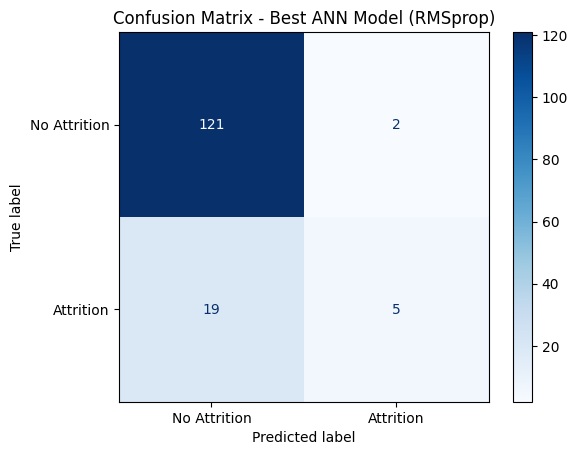

In [415]:
# ============================================================
# CONFUSION MATRIX
# ============================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best ANN Model (RMSprop)")
plt.show()


comparison BOTH MODELS/:

In [416]:
best_simple = max(results_simple, key=lambda k: results_simple[k]["f1"])
best_optimized = max(results_optimized, key=lambda k: results_optimized[k]["f1"])

simple_history = results_simple[best_simple]["history"]
optimized_history = results_optimized[best_optimized]["history"]


In [417]:
best_simple_name = max(
    results_simple,
    key=lambda k: results_simple[k]["f1"]
)

best_simple = results_simple[best_simple_name]

print("\n" + "="*60)
print(" BEST SIMPLE MODEL (Phase 3 – No Regularization)")
print("="*60)
print(f"Optimizer : {best_simple_name}")
print(f"Accuracy  : {best_simple['accuracy']:.4f}")
print(f"Precision : {best_simple['precision']:.4f}")
print(f"Recall    : {best_simple['recall']:.4f}")
print(f"F1-score  : {best_simple['f1']:.4f}")
print("="*60)



 BEST SIMPLE MODEL (Phase 3 – No Regularization)
Optimizer : SGD_with_Momentum
Accuracy  : 0.8912
Precision : 0.6538
Recall    : 0.7083
F1-score  : 0.6800


In [418]:
best_opt_name = max(
    results_optimized,
    key=lambda k: results_optimized[k]["f1"]
)

best_optimized = results_optimized[best_opt_name]

print("\n" + "="*60)
print(" BEST OPTIMIZED MODEL (Phase 4 – BN + Dropout)")
print("="*60)
print(f"Optimizer : {best_opt_name}")
print(f"Accuracy  : {best_optimized['accuracy']:.4f}")
print(f"Precision : {best_optimized['precision']:.4f}")
print(f"Recall    : {best_optimized['recall']:.4f}")
print(f"F1-score  : {best_optimized['f1']:.4f}")
print("="*60)



 BEST OPTIMIZED MODEL (Phase 4 – BN + Dropout)
Optimizer : Adam
Accuracy  : 0.8912
Precision : 0.7500
Recall    : 0.5000
F1-score  : 0.6000


In [419]:
print("\n" + "="*60)
print(" FINAL MODEL COMPARISON SUMMARY")
print("="*60)

print("Simple Model")
print(f"Optimizer : {best_simple_name}")
print(f"F1-score  : {best_simple['f1']:.4f}\n")

print("Optimized Model")
print(f"Optimizer : {best_opt_name}")
print(f"F1-score  : {best_optimized['f1']:.4f}")

if best_optimized["f1"] >= best_simple["f1"]:
    print("\n✔ Optimized model performs better or equal with reduced overfitting.")
else:
    print("\n✔ Simple model performs better but shows higher overfitting.")



 FINAL MODEL COMPARISON SUMMARY
Simple Model
Optimizer : SGD_with_Momentum
F1-score  : 0.6800

Optimized Model
Optimizer : Adam
F1-score  : 0.6000

✔ Simple model performs better but shows higher overfitting.


In [420]:
def overfitting_gap(history):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    return {
        "Accuracy Gap": train_acc - val_acc,
        "Loss Gap": val_loss - train_loss
    }

gap_simple = overfitting_gap(simple_history)
gap_optimized = overfitting_gap(optimized_history)

print("\n===== OVERFITTING GAP COMPARISON =====\n")

print("Simple Model")
for k, v in gap_simple.items():
    print(f"{k}: {v:.4f}")

print("\nOptimized Model")
for k, v in gap_optimized.items():
    print(f"{k}: {v:.4f}")



===== OVERFITTING GAP COMPARISON =====

Simple Model
Accuracy Gap: 0.1565
Loss Gap: 0.8668

Optimized Model
Accuracy Gap: 0.0432
Loss Gap: 0.1390


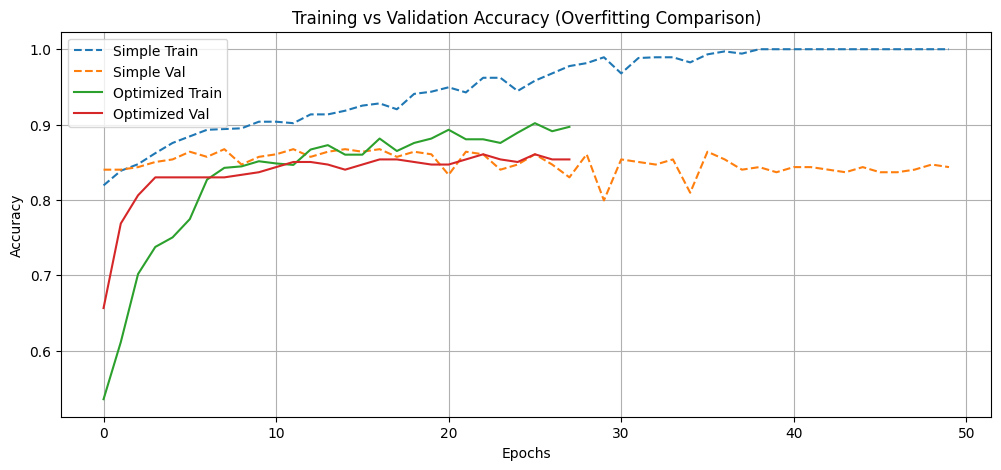

In [421]:
plt.figure(figsize=(12,5))

plt.plot(simple_history.history['accuracy'], label='Simple Train', linestyle='--')
plt.plot(simple_history.history['val_accuracy'], label='Simple Val', linestyle='--')

plt.plot(optimized_history.history['accuracy'], label='Optimized Train')
plt.plot(optimized_history.history['val_accuracy'], label='Optimized Val')

plt.title("Training vs Validation Accuracy (Overfitting Comparison)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


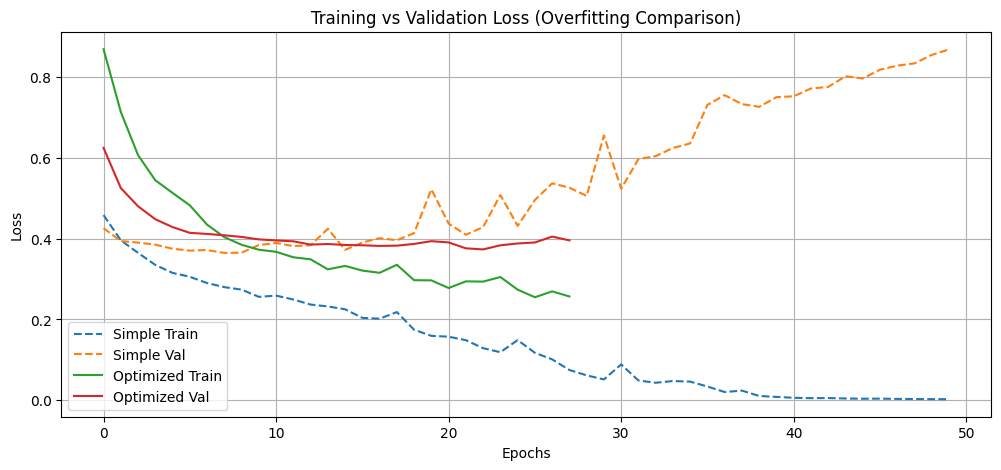

In [422]:
plt.figure(figsize=(12,5))

plt.plot(simple_history.history['loss'], label='Simple Train', linestyle='--')
plt.plot(simple_history.history['val_loss'], label='Simple Val', linestyle='--')

plt.plot(optimized_history.history['loss'], label='Optimized Train')
plt.plot(optimized_history.history['val_loss'], label='Optimized Val')

plt.title("Training vs Validation Loss (Overfitting Comparison)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [423]:
print("\n===== FINAL OVERFITTING CONCLUSION =====\n")

if gap_optimized["Accuracy Gap"] < gap_simple["Accuracy Gap"]:
    print("✔ Optimized model shows REDUCED overfitting.")
else:
    print("✘ Overfitting not improved.")

print("\nReason:")
print("- Batch Normalization stabilized learning")
print("- Dropout prevented neuron co-adaptation")



===== FINAL OVERFITTING CONCLUSION =====

✔ Optimized model shows REDUCED overfitting.

Reason:
- Batch Normalization stabilized learning
- Dropout prevented neuron co-adaptation


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


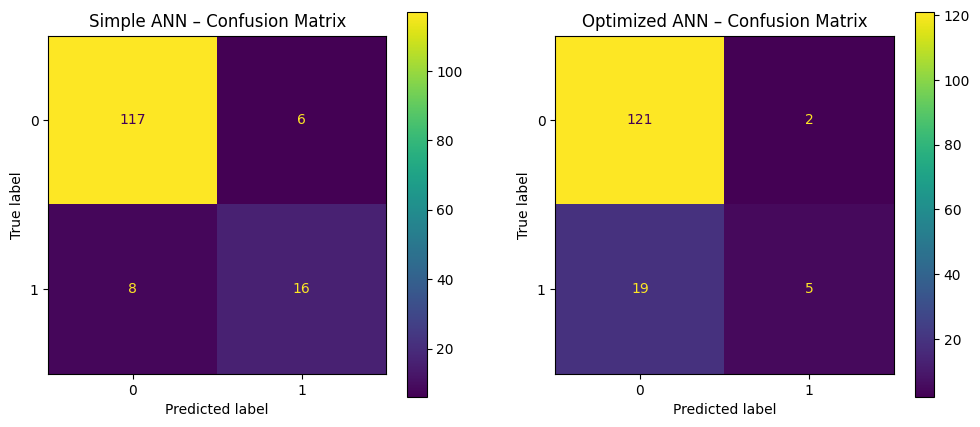

In [425]:
#CONFUSION MATRIX (MANDATORY – BOTH MODELS)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
y_pred_simple = (final_simple_model.predict(X_test_processed) > 0.5).astype(int)
y_pred_optimized = (best_model.predict(X_test_processed) > 0.5).astype(int)

# Confusion matrices
cm_simple = confusion_matrix(y_test, y_pred_simple)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_simple).plot(ax=axes[0], values_format='d')
axes[0].set_title("Simple ANN – Confusion Matrix")

ConfusionMatrixDisplay(cm_optimized).plot(ax=axes[1], values_format='d')
axes[1].set_title("Optimized ANN – Confusion Matrix")

plt.show()


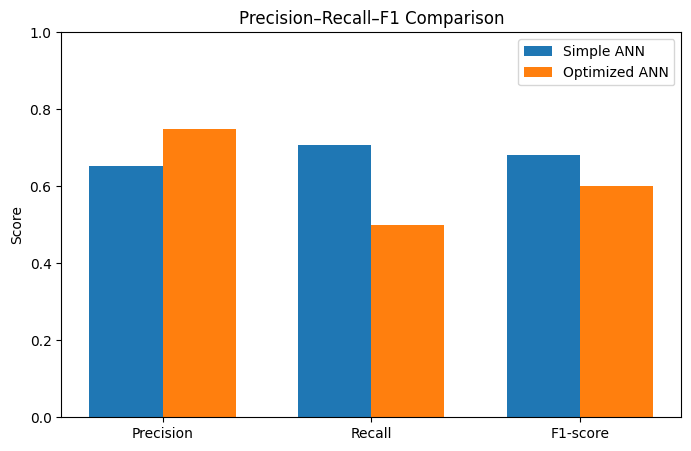

In [426]:
#PRECISION–RECALL–F1 BAR COMPARISON (VERY IMPORTANT)
import numpy as np

metrics = ['Precision', 'Recall', 'F1-score']

simple_scores = [
    best_simple['precision'],
    best_simple['recall'],
    best_simple['f1']
]

optimized_scores = [
    best_optimized['precision'],
    best_optimized['recall'],
    best_optimized['f1']
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, simple_scores, width, label='Simple ANN')
plt.bar(x + width/2, optimized_scores, width, label='Optimized ANN')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Precision–Recall–F1 Comparison")
plt.legend()
plt.ylim(0,1)
plt.show()
